## Try to correlate MERSCOPE identified MD cells to scRNAseq

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import re
# plt.rcParams['font.size'] = 16

In [2]:
# Load in thalamus dataset
thData = sc.read("../Data/thData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
thData[:,"Syndig1l"].X

<66800x1 sparse matrix of type '<class 'numpy.float32'>'
	with 33311 stored elements in Compressed Sparse Row format>

In [32]:
for name in thData.obs["subclass_label"].unique():
    print(name)

TH/HY Gbx2 Zim1
Endo
TH/HY Gata3
TH/HY Pth2
TH Tfap2d
TH LH_Pou4f1_Sox1
TH Pitx2
TH PF_Fzd5
TH_Rxfp1_Epb4
TH Prkcd_Grin2c
TH PVT_Ntrk1
TH AV_Col27a1
TH MH_Tac2
Astro
HY/TH Gnb3
TH/HY Pax6
TH/HY Gbx2 Fmo1
TH Otx2
HY Lhx1
TH Serpinb7
HY Foxa1
HY Pitx2


In [30]:
for name in x.obs["cluster_label"].unique():
    print(name)

View of AnnData object with n_obs × n_vars = 338 × 23431
    obs: 'sample_id', 'umi_counts', 'gene_counts', 'sex', 'facs', 'roi', 'roi_label', 'roi_color', 'cl', 'cluster_id', 'cluster_label', 'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color', 'class_id', 'class_label', 'class_color', 'forebrain_cluster_label', 'forebrain_subclass_label', 'forebrain_neighborhood_label', 'qc'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cl_colors', 'class_id_colors', 'class_label_colors', 'cluster_id_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [39]:
clSubset = thData[thData.obs["cluster_label"].isin(["2013_TH Prkcd_Grin2c"])]

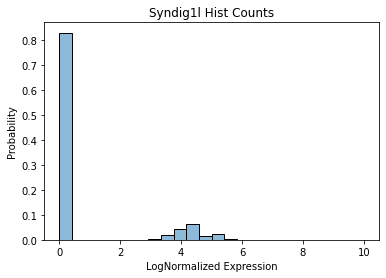

In [40]:
# Look at Syndig1l expression
gene = "Syndig1l"
bins = np.linspace(0,10,25)

# Plot histogram of requested gene expression
ax = sns.histplot(clSubset[:,gene].X.A,stat="probability",bins=bins)
ax.get_legend().remove()
plt.title(gene + ' Hist Counts')
plt.xlabel('LogNormalized Expression');

In [44]:
posCells = clSubset[clSubset[:,gene].X > 0]

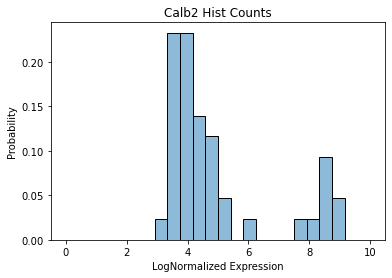

In [49]:
# Look at Syndig1l expression
gene = "Calb2"
bins = np.linspace(0,10,25)

# Plot histogram of requested gene expression
ax = sns.histplot(posCells[:,gene].X.A,stat="probability",bins=bins)
ax.get_legend().remove()
plt.title(gene + ' Hist Counts')
plt.xlabel('LogNormalized Expression');

In [181]:
# Create Prkcd cluster colors for plotting

# Assemble unique clusters across both MERFISH and scRNAseq data sets
clList = set(['1987_TH Prkcd_Grin2c', '1988_TH Prkcd_Grin2c', '1989_TH Prkcd_Grin2c', '1990_TH Prkcd_Grin2c', 
              '1991_TH Prkcd_Grin2c', '1993_TH Prkcd_Grin2c', '1994_TH Prkcd_Grin2c', '1995_TH Prkcd_Grin2c', 
              '1996_TH Prkcd_Grin2c', '1997_TH Prkcd_Grin2c', '1998_TH Prkcd_Grin2c', '1999_TH Prkcd_Grin2c',
              '2000_TH Prkcd_Grin2c', '2001_TH Prkcd_Grin2c', '2002_TH Prkcd_Grin2c', '2005_TH Prkcd_Grin2c', 
              '2006_TH Prkcd_Grin2c', '2007_TH Prkcd_Grin2c', '2008_TH Prkcd_Grin2c', '2009_TH Prkcd_Grin2c', 
              '2010_TH Prkcd_Grin2c', '2011_TH Prkcd_Grin2c', '2012_TH Prkcd_Grin2c', '2013_TH Prkcd_Grin2c', 
              '2014_TH Prkcd_Grin2c', '2015_TH Prkcd_Grin2c', '2016_TH Prkcd_Grin2c', '2017_TH Prkcd_Grin2c', 
              '2018_TH Prkcd_Grin2c', '2019_TH Prkcd_Grin2c', '2020_TH Prkcd_Grin2c', '2022_TH Prkcd_Grin2c', 
              '2023_TH Prkcd_Grin2c', '2024_TH Prkcd_Grin2c', '2025_TH Prkcd_Grin2c', '2026_TH Prkcd_Grin2c'])

# # Establish color dict with all clusters present across both data sets
# clColors = sns.color_palette("Spectral_r", n_colors=len(clList))
# colorDict = {}

# for count, cl in enumerate(sorted(clList)):
#     colorDict[cl] = clColors[count]

# Establish color dict with all clusters present across both data sets
colorDict = dict(zip(sorted(clList),sns.color_palette("Spectral", n_colors=len(clList))))

# Remove colors not present in MERFISH data set
rmClusters = clList - set(roiData.obs["cluster_label"])
for cl in rmClusters:
    del(colorDict[cl])

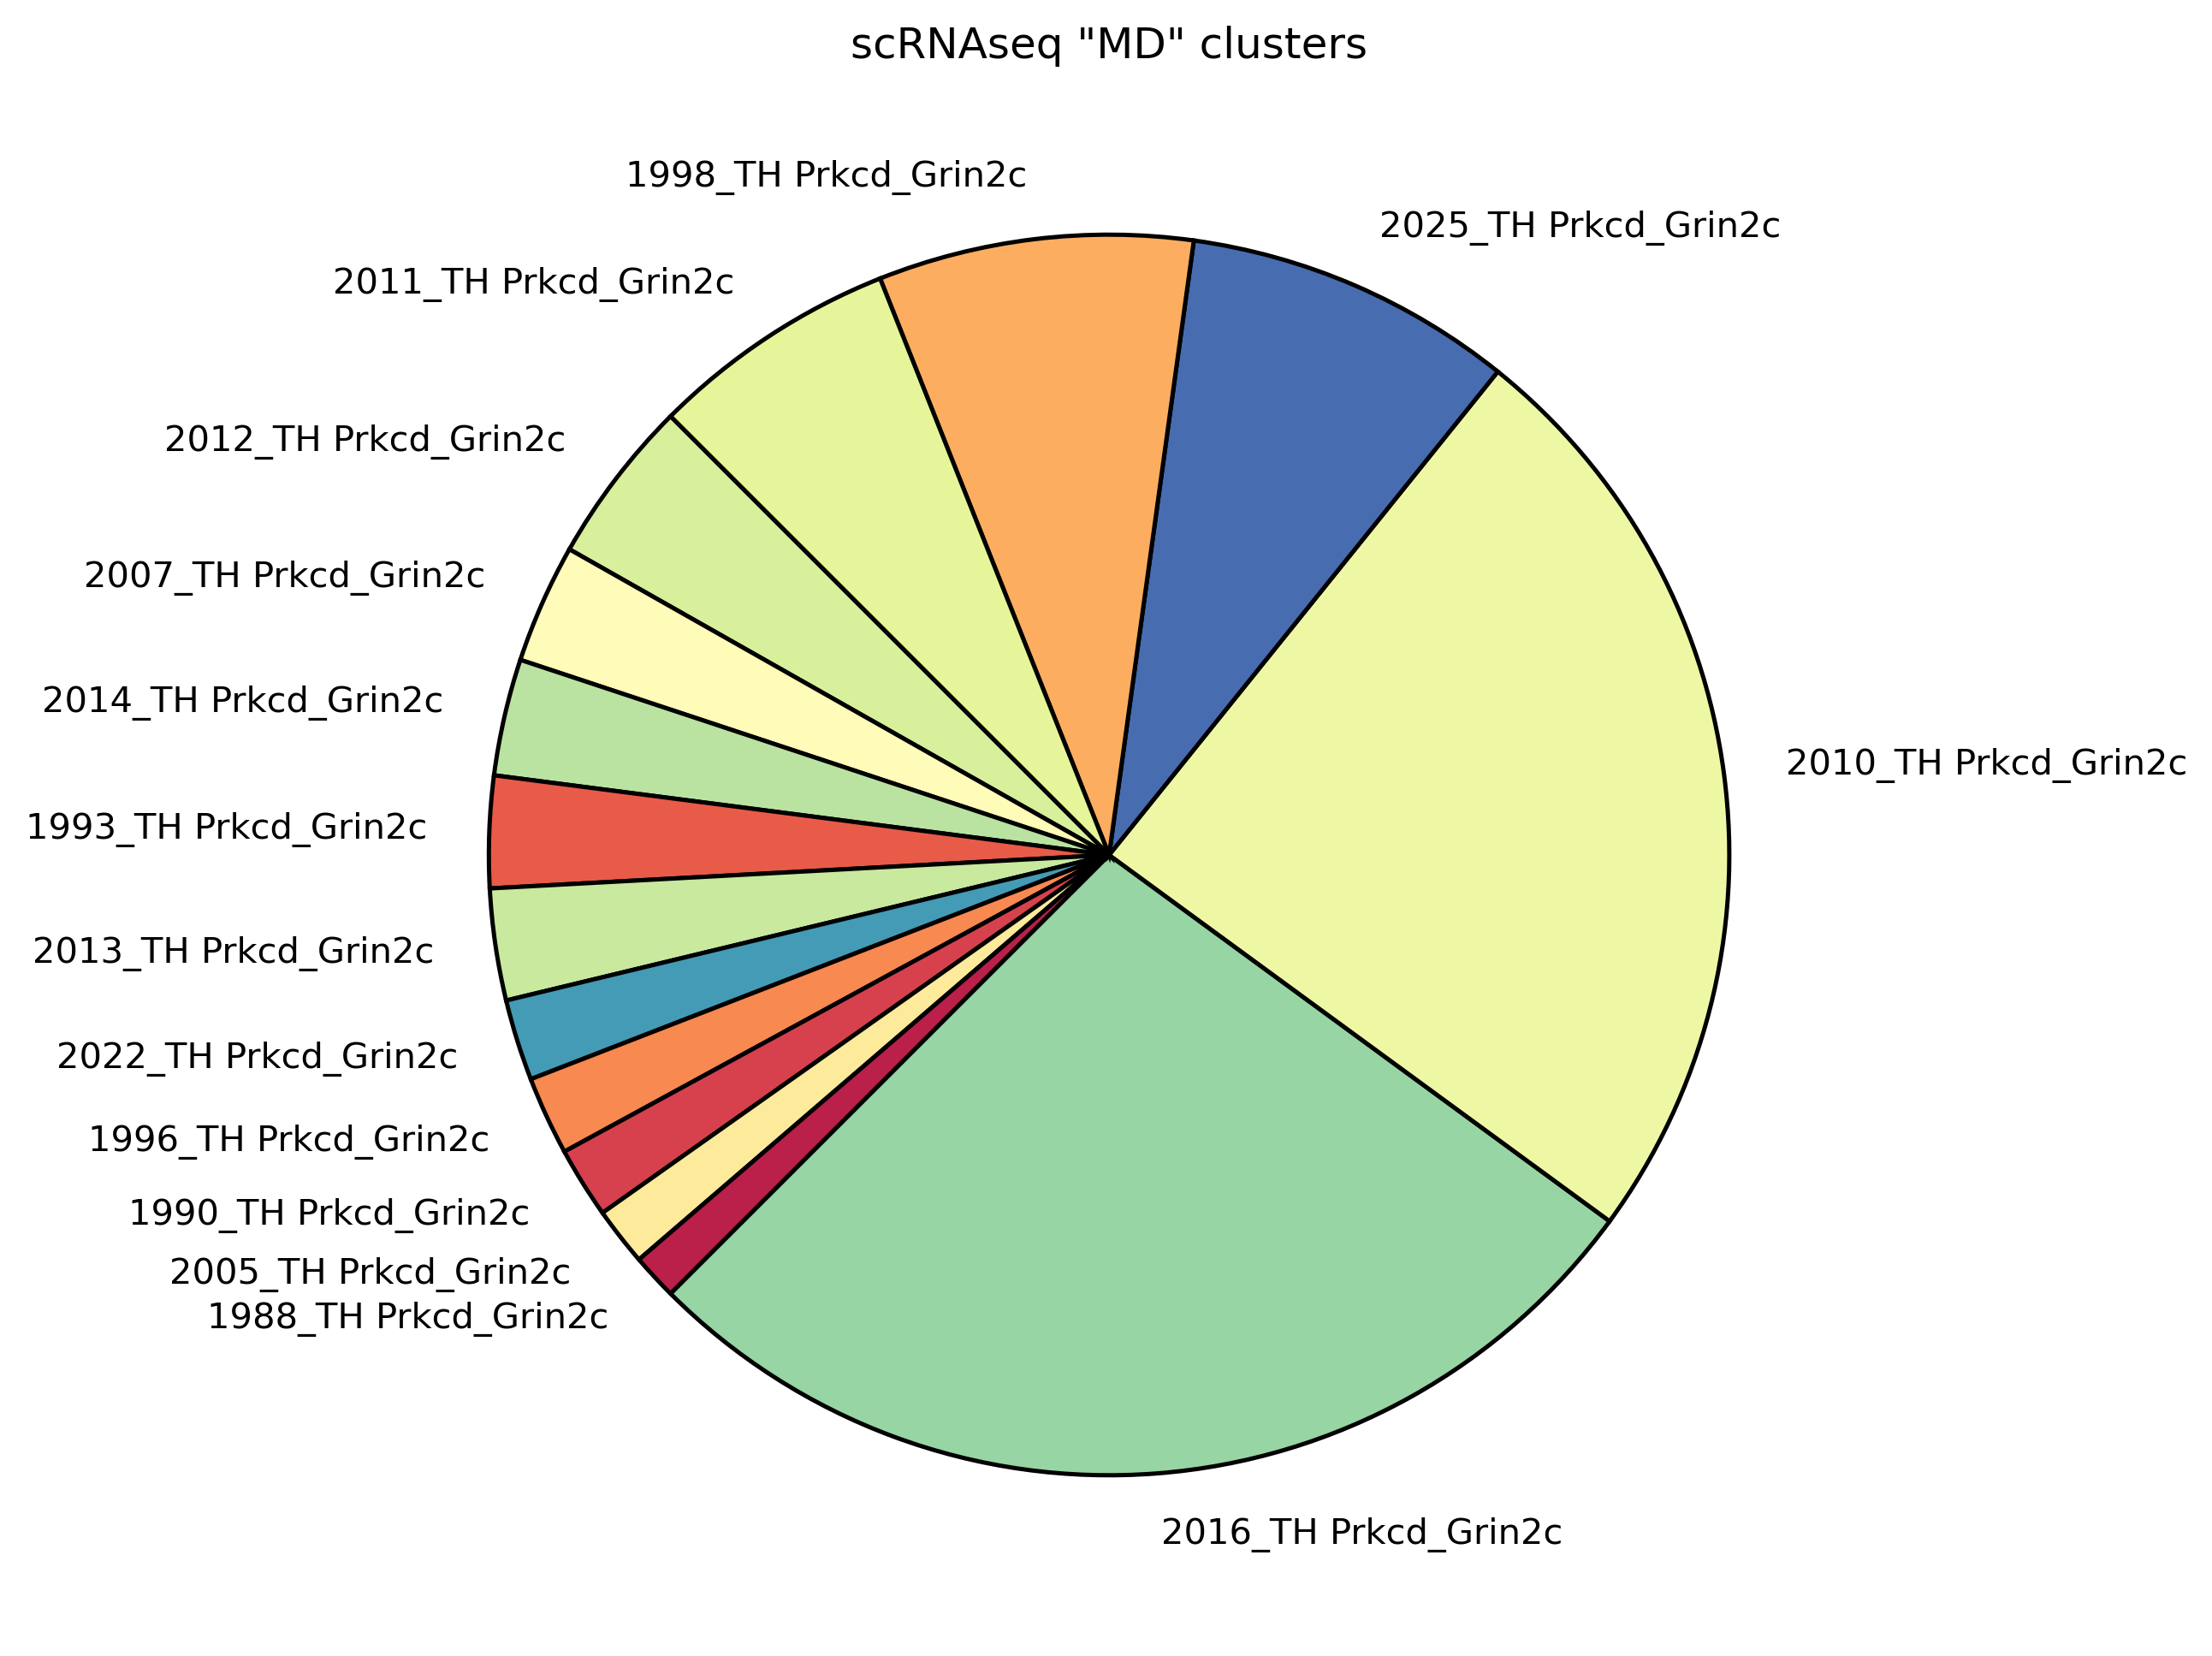

In [184]:
# Look at cluster proportions in "MD" roi
roiData = thData[thData.obs["roi"].isin(["TH - MD-IMD-PCN-CL"])]
roiData = roiData[roiData.obs["subclass_label"].isin(["TH Prkcd_Grin2c"])]

# Count number of types in this selection
nToPlot = 15
groupby = "cluster_label"
subclassTypes = np.unique(roiData.obs[groupby])
gluCounts = pd.DataFrame({'counts' : [sum(roiData.obs[groupby] == name) for name in subclassTypes]}, index = subclassTypes)
z = gluCounts.sort_values('counts', ascending=False).head(nToPlot)
plt.figure(figsize=[16,8], dpi=300)
z = gluCounts.sort_values('counts', ascending=False).head(nToPlot)
plt.pie(z["counts"],labels=z.index,colors = [colorDict[key] for key in z.index],startangle = 225,
       wedgeprops={"edgecolor":"k",'linewidth': 1.2, 'antialiased': True});
plt.title('scRNAseq "MD" clusters');

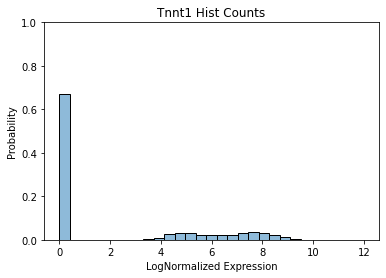

In [64]:
# Look at Syndig1l expression
gene = "Tnnt1"
bins = np.linspace(0,12,30)

# Plot histogram of requested gene expression
ax = sns.histplot(roiData[:,gene].X.A,stat="probability",bins=bins)
ax.get_legend().remove()
plt.title(gene + ' Hist Counts')
plt.ylim([0, 1])
plt.xlabel('LogNormalized Expression');

In [50]:
gene = "Syndig1l"
synCells = thData[thData[:,gene].X > 0]

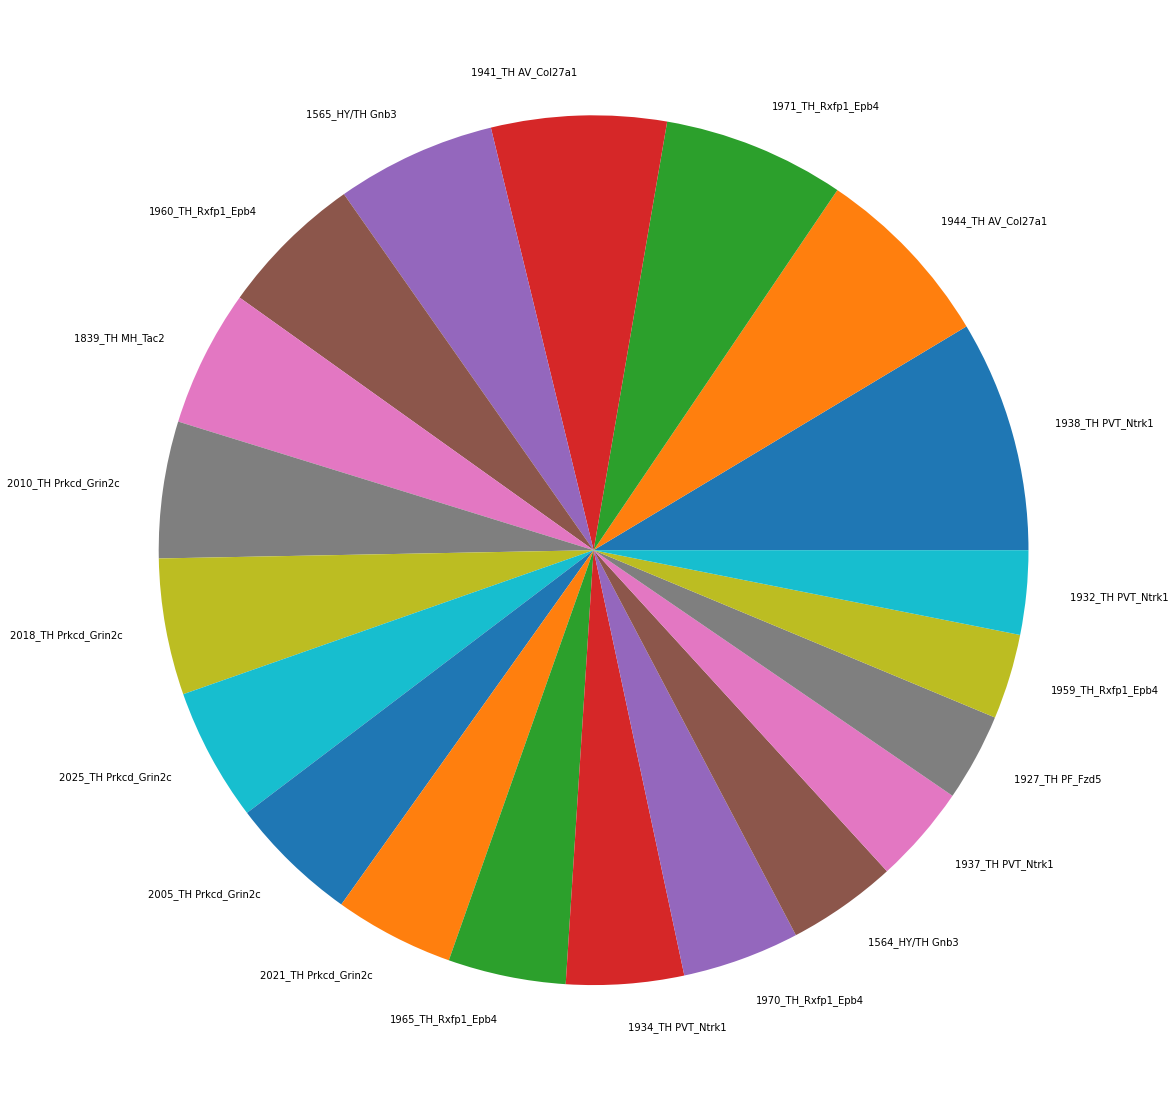

In [52]:
# Count number of types in this selection
groupby = "cluster_label"
subclassTypes = np.unique(synCells.obs[groupby])
gluCounts = pd.DataFrame({'counts' : [sum(synCells.obs[groupby] == name) for name in subclassTypes]}, index = subclassTypes)
z = gluCounts.sort_values('counts', ascending=False).head(20)
plt.figure(figsize=[40,20])
z = gluCounts.sort_values('counts', ascending=False).head(20)
plt.pie(z["counts"],labels=z.index);

In [ ]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig